In [1]:
from ucimlrepo import fetch_ucirepo 
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import numpy as np
import featurize as ft
from functools import partial
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd

## Download data

In [2]:
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
data = abalone.data.features 
target = abalone.data.targets["Rings"] 

# for label in "MFI":
#     data[label] = (data["Sex"] == label).astype(int)
# del data["Sex"]

numeric_features = ["Length", "Diameter", "Height",	"Whole_weight",	"Shucked_weight",	"Viscera_weight",	"Shell_weight"]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['Sex',]
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipe = Pipeline(steps=[('preprocessor', preprocessor),])
data = pipe.fit(data).transform(data)

cols = columns=numeric_features + list(pipe["preprocessor"].transformers_[1][1].get_feature_names_out(categorical_features))
data = pd.DataFrame(data, columns=cols)

data

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_F,Sex_I,Sex_M
0,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217,0.0,0.0,1.0
1,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987,0.0,0.0,1.0
2,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139,1.0,0.0,0.0
3,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294,0.0,0.0,1.0
4,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4172,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062,1.0,0.0,0.0
4173,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685,0.0,0.0,1.0
4174,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955,0.0,0.0,1.0
4175,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739,1.0,0.0,0.0


## Baseline model

In [3]:
N_SPLITS = 3
strat_kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=8888)
scores = np.empty(N_SPLITS)
for idx, (train_idx, test_idx) in enumerate(strat_kf.split(data, target)):
    X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
    y_train, y_test = target[train_idx], target[test_idx]

    clf = KNeighborsClassifier()
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)
    loss = accuracy_score(y_test, preds)
    scores[idx] = loss

print(scores.mean())

0.22192946808481376


## Featurize

In [5]:
# feats = ft.featurize(
#     data,
#     target,
#     problem_type="classification",
#     feature_depth=1,
#     mrmr_k=75,
#     swarm_particles=50,
#     swarm_iters=100,
# )

f = partial(ft.cost_funcs.classification.knn_accuracy, X=data, y=target)

ga = ft.selection.BinaryGeneticAlgorithm(
    cost_func=f, population_size=30, num_genes=data.shape[1], max_iters=50
)

cost, genome = ga.optimize()

feats = data[data.columns[genome == 1]]

print(f"Best cost: {cost}, total features: {genome.sum()}")

Optimising feature space...:   0%|          | 0/50 [00:00<?, ?it/s]

Optimising feature space...:  26%|██▌       | 13/50 [00:40<01:54,  3.09s/it]

Best cost: 0.7562820946549936, total features: 7


In [6]:
N_SPLITS = 3
strat_kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=8888)
scores = np.empty(N_SPLITS)
for idx, (train_idx, test_idx) in enumerate(strat_kf.split(feats, target)):
    X_train, X_test = feats.iloc[train_idx], feats.iloc[test_idx]
    y_train, y_test = target[train_idx], target[test_idx]

    clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2, leaf_size=30, algorithm="brute")
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)
    loss = accuracy_score(y_test, preds)
    scores[idx] = loss

print(scores.mean())

0.24371790534500637


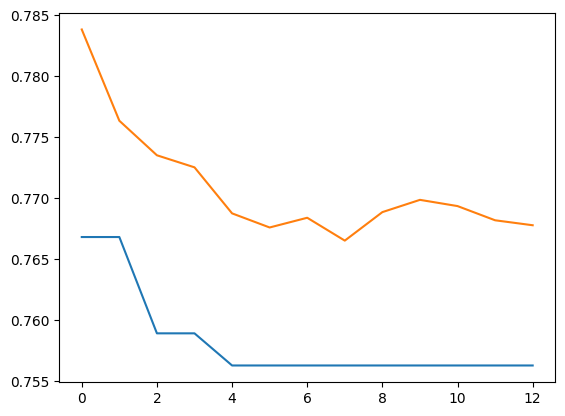

In [7]:
# plot ga history_best and history_avg on same plot
plt.plot(ga.history_best, label="Best")
plt.plot(ga.history_mean, label="Avg")

In [ ]:
feats = ft.featurize(
    data,
    target,
    problem_type="classification",
    feature_depth=1,
    mrmr_k=100,
    swarm_particles=50,
    swarm_iters=100,
)

f = partial(ft.cost_funcs.classification.knn_accuracy, X=data, y=target)

ga = ft.selection.GeneticAlgorithm(
    cost_func=f, num_individuals=50, num_features=data.shape[1], max_iters=100
)

cost, genome = ga.optimize()

feats = data[data.columns[genome == 1]]

print(f"Best cost: {cost}, total features: {genome.sum()}")

In [ ]:
N_SPLITS = 3
strat_kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=8888)
scores = np.empty(N_SPLITS)
for idx, (train_idx, test_idx) in enumerate(strat_kf.split(feats, target)):
    X_train, X_test = feats.iloc[train_idx], feats.iloc[test_idx]
    y_train, y_test = target[train_idx], target[test_idx]

    clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2, leaf_size=30, algorithm="brute")
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)
    loss = accuracy_score(y_test, preds)
    scores[idx] = loss

print(scores.mean())

In [ ]:
# plot ga history_best and history_avg on same plot
plt.plot(ga.history_best, label="Best")
plt.plot(ga.history_mean, label="Avg")

In [ ]:
data.isna().sum()